# Smooth Filter Throughput

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 25th   2022
- last update : September 25th2022


### 

- **kernel anaconda3_auxtel** at CC or **python 3** locally

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [3]:
from scipy import fftpack

In [4]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [5]:
path="spectractor_tables"
filename_filterblue = "BG40.txt"
filename_filterred = "FELH0600.txt"

In [6]:
arr1=np.loadtxt(os.path.join(path,filename_filterblue))
arr2=np.loadtxt(os.path.join(path,filename_filterred))

In [7]:
wl1 = arr1[:,0]
tr1 = arr1[:,1]

In [8]:
wl2 = arr2[:,0]
tr2 = arr2[:,1]

# Plot

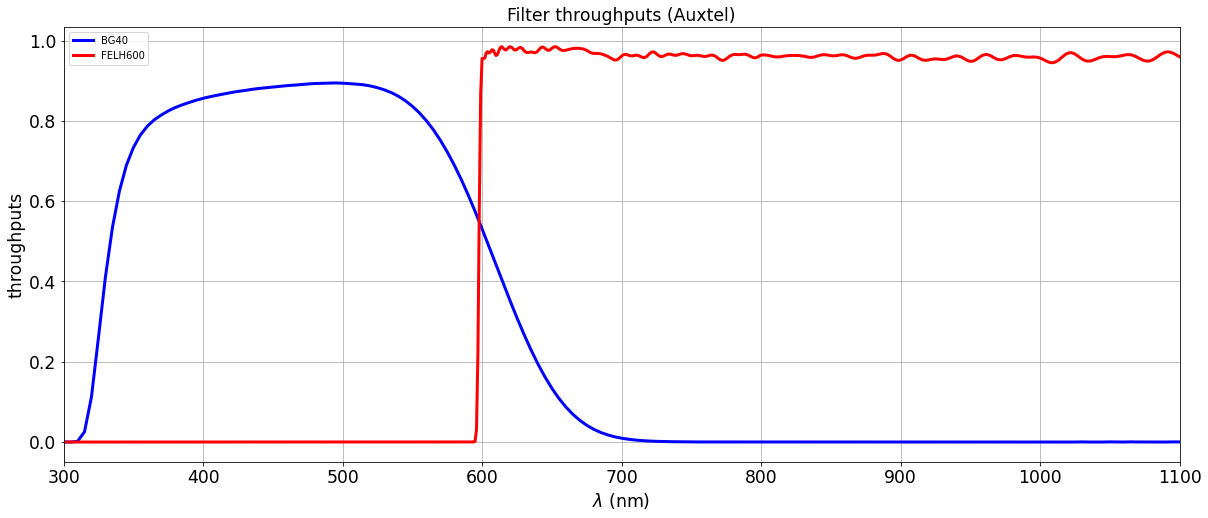

In [9]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(1,1,1)

ax.plot(wl1,tr1,'b-',label="BG40",lw=3)
ax.plot(wl2,tr2,'r-',label="FELH600",lw=3)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Filter throughputs (Auxtel)")
ax.grid()
ax.set_ylabel("throughputs")
ax.set_xlim(300,1100)
plt.savefig("auxtel_filter_throughputs_linscale.png")
plt.show()

# Smoothing of the filter red filter

In [10]:
from scipy.signal import savgol_filter
#span=51
#tr2_smo = savgol_filter(tr2, span, 5) # window size 51, polynomial order 3
span=11
tr2_smo =  smooth_data_convolve_my_average(tr2, span)
#tr2_smo =  smooth_data_fft(tr2, span)

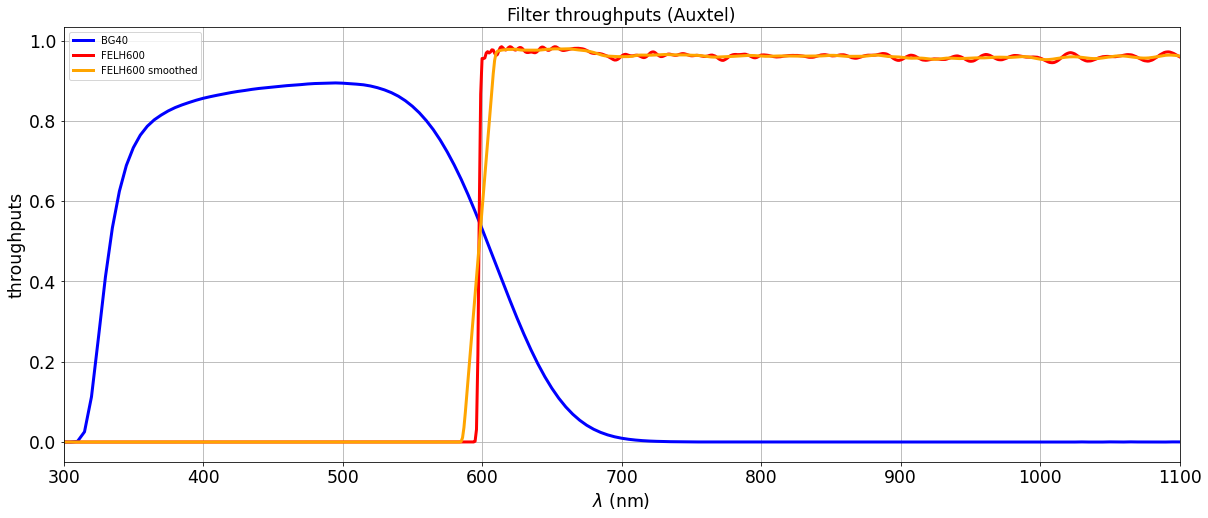

In [11]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(1,1,1)

ax.plot(wl1,tr1,'b-',label="BG40",lw=3)
ax.plot(wl2,tr2,'r-',label="FELH600",lw=3)
ax.plot(wl2,tr2_smo,'-',color="orange",label="FELH600 smoothed",lw=3)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Filter throughputs (Auxtel)")
ax.grid()
ax.set_ylabel("throughputs")
ax.set_xlim(300,1100)
plt.savefig("auxtel_filter_throughputs_smooth_linscale.png")
plt.show()

# Keep the fast transition and then filter

In [14]:
tr2_final = np.where(wl2<600+span,tr2,tr2_smo)

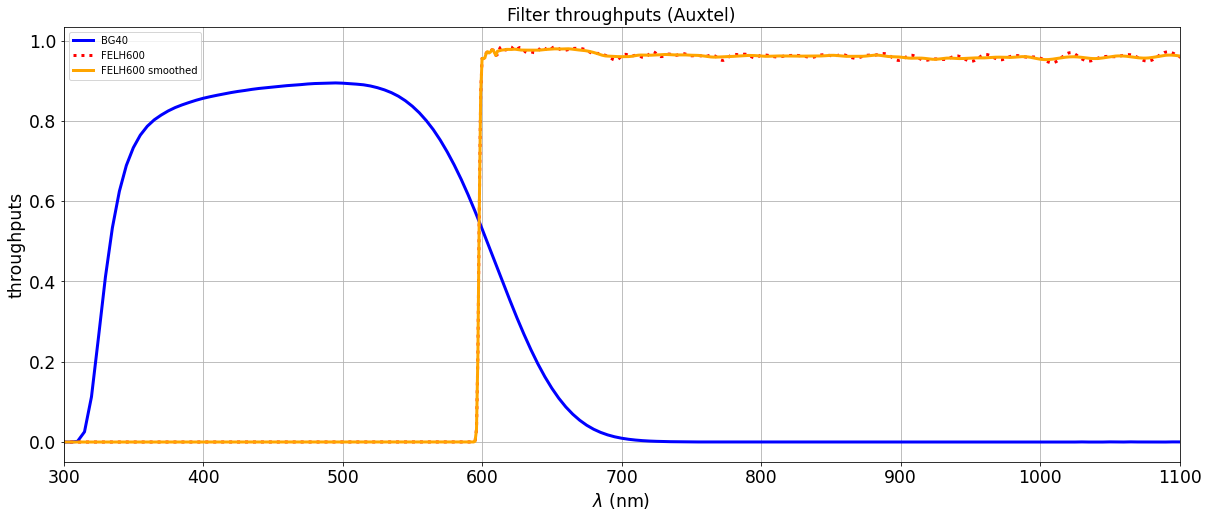

In [16]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(1,1,1)

ax.plot(wl1,tr1,'b-',label="BG40",lw=3)
ax.plot(wl2,tr2,'r:',label="FELH600",lw=3)
ax.plot(wl2,tr2_final,'-',color="orange",label="FELH600 smoothed",lw=3)
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Filter throughputs (Auxtel)")
ax.grid()
ax.set_ylabel("throughputs")
ax.set_xlim(300,1100)
plt.savefig("auxtel_filter_throughputs_smooth_linscale.png")
plt.show()

In [32]:
indexes = np.where(np.logical_and(wl2>600+2*span,wl2<1100))

In [33]:
data = tr2_final[indexes]

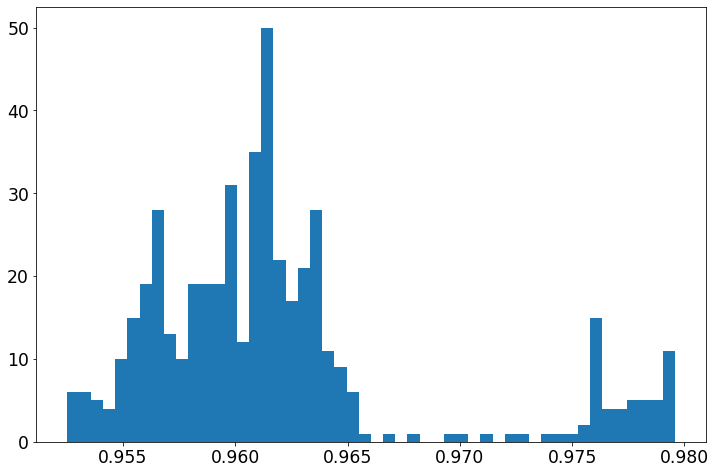

In [34]:
plt.hist(data,bins=50);

- transmission around 96%

In [13]:
assert False

AssertionError: 

# Demo

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also: 

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        msg = ValueError + "smooth only accepts 1 dimension arrays."
        raise msg
        
    if x.size < window_len:
        msg = ValueError + "Input vector needs to be bigger than window size."
        raise msg

    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        msg = ValueError +  "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        raise msg


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y





In [ ]:
def smooth_demo():

    t=wl2
    x=tr2
    y=smooth(x)

    ws=31

    fig = plt.figure()
    fig.add_subplot(2,1,1)
    ax.plot(np.ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    #ax.hold(True)
    for w in windows[1:]:
        eval('ax.plot('+w+'(ws) )')

    ax.axis([0,30,0,1.1])

    ax.legend(windows)
    ax.set_title("The smoothing windows")
    fig.add_subplot(2,1,2)
    ax.plot(x)
    for w in windows:
        ax.plot(smooth(x,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    ax.legend(l)
    ax.set_title("Smoothing a noisy signal")
    show()


In [ ]:
smooth_demo()
